<a href="https://colab.research.google.com/github/adityachoudharyclg/pytorchBasics/blob/master/Deep_neural_networks_on_GPU_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import numpy as np
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [0]:
dataset=MNIST(root='data/',download=True,transform=ToTensor())

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
def split_indices(n,val_pct):
    # Size of validation set
    n_val=int(val_pct*n)
    idxs=np.random.permutation(n)
    train_set_indices=idxs[n_val:]
    val_set_indices=idxs[:n_val]
    return train_set_indices,val_set_indices

In [0]:
train_indices,val_indices=split_indices(len(dataset),val_pct=0.2)
print(len(train_indices),len(val_indices))
print('Sample val indices: ', val_indices[:20])

48000 12000
Sample val indices:  [26720 31304 35831 55723 24573 31740 57034  2900 38307 34478  4991 28732
 55211 36651  5130 39917 51651 40342 16331 11580]


In [0]:
# Using SubsetRandomSampler(Same type of work can be done using random split)
batch_size=128

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset, 
                      batch_size, 
                      sampler=train_sampler)

# Validation sampler and data loader
valid_sampler = SubsetRandomSampler(val_indices)
valid_dl = DataLoader(dataset,
                    batch_size, 
                    sampler=valid_sampler)

In [0]:
import torch.nn.functional as F
import torch.nn as nn

In [0]:
class MnistModel(nn.Module):
    def __init__(self,in_size,hidden_size,out_size):
        super().__init__()
        # hidden layer
        self.linear1=nn.Linear(in_size,hidden_size)
        # output layer
        self.linear2=nn.Linear(hidden_size,out_size)
    
    def forward(self,xb):
        # Flatten image tensors
        xb=xb.view(xb.size(0),-1)#size analogous to shape
        # Intermediate outputs
        out=self.linear1(xb)
        # Applying activation function
        out=F.relu(out)
        # getting predictions
        out=self.linear2(out)
        return out

In [0]:
input_size = 784
num_classes = 10

model = MnistModel(input_size, hidden_size=64, 
                   out_size=num_classes)

In [0]:
for t in model.parameters():
    print(t.shape)

torch.Size([64, 784])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


In [0]:
for images, labels in train_dl:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.2901384830474854
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.1445,  0.0644, -0.0410, -0.0642,  0.1067,  0.0047,  0.0108, -0.2071,
         -0.2186,  0.1347],
        [ 0.1172,  0.1025,  0.0142, -0.0828,  0.1190, -0.1319,  0.0744, -0.1497,
         -0.2141,  0.0616]])


Using a GPU

In [0]:
torch.cuda.is_available()

True

In [0]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [0]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [0]:
for images, labels in train_dl:
    print(images.shape)
    device=get_default_device()
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


In [0]:
class DeviceDataLoader():
    # Convenient for moving data to device
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
    
    def __len__(self):
        """ Number of batches """
        return len(self.dl)

In [0]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [0]:
for xb, yb in valid_dl:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([7, 6, 9, 1, 6, 1, 3, 9, 3, 8, 2, 4, 7, 4, 8, 1, 6, 4, 8, 1, 1, 3, 1, 0,
        9, 4, 2, 4, 1, 6, 4, 7, 6, 5, 3, 7, 3, 3, 6, 2, 2, 4, 6, 7, 0, 1, 9, 3,
        0, 7, 5, 9, 5, 7, 8, 3, 5, 8, 3, 0, 1, 6, 6, 0, 5, 2, 4, 7, 9, 9, 8, 8,
        7, 6, 2, 4, 3, 6, 4, 8, 4, 2, 2, 5, 5, 7, 3, 3, 7, 6, 2, 5, 0, 3, 9, 0,
        7, 5, 9, 6, 5, 9, 3, 0, 5, 0, 1, 6, 7, 1, 8, 2, 4, 5, 2, 2, 1, 3, 0, 9,
        9, 1, 5, 5, 0, 4, 5, 9], device='cuda:0')


Training the model

In [0]:
def loss_batch(model,loss_func,xb,yb,opt=None,metric=None):
    preds=model(xb)
    loss=loss_func(preds,yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    metric_result=None
    if metric is not None:
        metric_result=metric(preds,yb)
    
    return loss.item(),len(xb),metric_result

In [0]:
def evaluate(model,loss_func,valid_dl,metric=None):
    results=[loss_batch(model,loss_func,xb,yb,metric=metric) for xb,yb in valid_dl]
    losses,nums,metrics=zip(*results)
    total=np.sum(nums)
    avg_loss=np.sum(np.multiply(losses,nums))/total
    avg_metric=None
    if metric is not None:
            # Avg. of metric across batches
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
    return avg_loss, total, avg_metric

In [0]:
def fit(epochs, lr, model, loss_fn, train_dl, 
        valid_dl, metric=None, opt_fn=None):
    losses, metrics = [], []
    
    # Instantiate the optimizer
    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        # Training
        for xb,yb in train_dl:
            loss,_,_ = loss_batch(model, loss_fn, xb, yb, opt)

        # Evaluation
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result
        
        # Record the loss & metric
        losses.append(val_loss)
        metrics.append(val_metric)
        
        # Print progress
        if metric is None:
            print('Epoch [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, epochs, val_loss))
        else:
            print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'
                  .format(epoch+1, epochs, val_loss, 
                          metric.__name__, val_metric))
    return losses, metrics

In [0]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [0]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=64, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=10, bias=True)
)

In [0]:
val_loss, total, val_acc = evaluate(model, F.cross_entropy, 
                                    valid_dl, metric=accuracy)
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))

Loss: 2.3151, Accuracy: 0.0793


In [0]:
losses, metrics = fit(10, 0.3, model, F.cross_entropy, 
                        train_dl, valid_dl, accuracy)

Epoch [1/10], Loss: 0.2452, accuracy: 0.9297
Epoch [2/10], Loss: 0.1719, accuracy: 0.9516
Epoch [3/10], Loss: 0.1481, accuracy: 0.9559
Epoch [4/10], Loss: 0.1438, accuracy: 0.9583
Epoch [5/10], Loss: 0.1152, accuracy: 0.9663
Epoch [6/10], Loss: 0.1020, accuracy: 0.9696
Epoch [7/10], Loss: 0.1004, accuracy: 0.9700
Epoch [8/10], Loss: 0.0964, accuracy: 0.9724
Epoch [9/10], Loss: 0.0923, accuracy: 0.9732
Epoch [10/10], Loss: 0.0884, accuracy: 0.9724


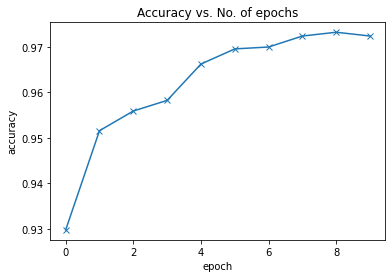

In [0]:
import matplotlib.pyplot as plt
accuracies = metrics
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');